# 1. Introduction

Accurate ship classification from aerial imagery is critical for a wide range of maritime applications—from port security and traffic monitoring to search‐and‐rescue operations and naval intelligence. However, real‐world platforms such as medium‑ or low-altitude UAVs frequently produce images of varying quality, due to motion blur, atmospheric haze, sensor noise, and occlusion. A classifier that produces only a single “hard” label can be dangerously overconfident when presented with low‑quality frames, potentially leading to misidentification of vessel types and consequential operational errors.

In this notebook, we present a reproducible pipeline that (1) quantifies image quality via a no‑reference composite metric, (2) trains deep classifiers that are explicitly encouraged to lower confidence on degraded inputs via entropy regularization, and (3) implements quality‑aware conformal prediction to provide set‑valued outputs with formal coverage guarantees. Our contributions are:  
- **Composite Quality Scoring**: combining different quality measures measures into a single score.  
- **Entropy‑Regularized Training**: a simple loss augmentation that forces the model to “know when it doesn’t know,” yielding more cautious confidence on low‑quality images.  
- **Quality‑Dependent Conformal Prediction**: per‐quality‑bin calibration of nonconformity thresholds, so that prediction sets expand under poor visibility while remaining tight when imagery is clear.

In [1]:
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# 2. Dataset Preparation

In this section we load and clean the **Fine-Grained Ship Classification** (FGSC-23) dataset introduce by Zhang et al. (2020) to produce a high‑quality, balanced dataset for training and evaluation. We will:

1. Load the raw images and inspect class distributions.
2. Remove near‑duplicate samples to prevent memorization bias.

## 2.1. Data Loading and Overview

We begin by loading the FGSC-23 ship classification dataset directly from the Hugging Face Datasets Hub. Key steps:

- **Class enumeration**  
  Use the dataset's metadata to obtain fine‑grained ship labels and their corresponding class indices.  
- **Sample counts**  
  Compute and display the number of images per class to reveal any imbalance.  
- **Representative examples**  
  Show a small random subset of images for each class to verify visual consistency and label correctness.

In [2]:
import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset

ds = load_dataset("jbourcier/fgsc23")

In [3]:
# Mapping integer labels (0–22) to human-readable ship class names from Zhang et al. (2023)
label_map = {
    0:  "Non-ship",
    1:  "Aircraft carrier",
    12:  "Destroyer",
    16:  "Landing craft",
    17:  "Frigate",
    18:  "Amphibious transport dock",
    19:  "Cruiser",
    20:  "Tarawa-class amphibious assault ship",
    21:  "Amphibious assault ship",
    22:  "Command ship",
    2: "Submarine",
    3: "Medical ship",
    4: "Combat boat",
    5: "Auxiliary ship",
    6: "Container ship",
    7: "Car carrier",
    8: "Hovercraft",
    9: "Bulk carrier",
    10: "Oil tanker",
    11: "Fishing boat",
    13: "Passenger ship",
    14: "Liquefied gas ship",
    15: "Barge"
}

In [4]:
import pandas as pd

# Extract labels from the train split
labels = ds['train']['label']

# Map integer labels to string labels
string_labels = [label_map[lbl] for lbl in labels]

# Compute class counts
class_counts = pd.Series(string_labels).value_counts().sort_index()

# Display as a DataFrame, sorted by count descending
class_distribution = pd.DataFrame({
    'Class Index': [list(label_map.values()).index(name) for name in class_counts.index],
    'Class Name': class_counts.index,
    'Count': class_counts.values,
}).sort_values('Count', ascending=False).reset_index(drop=True)
print(class_distribution)

    Class Index                            Class Name  Count
0             2                             Destroyer    542
1             0                              Non-ship    484
2            17                          Bulk carrier    343
3             4                               Frigate    295
4             6                               Cruiser    293
5            10                             Submarine    238
6            13                        Auxiliary ship    225
7             1                      Aircraft carrier    166
8            18                            Oil tanker    165
9             8               Amphibious assault ship    154
10           12                           Combat boat    143
11           16                            Hovercraft    120
12            3                         Landing craft    108
13           19                          Fishing boat    102
14           14                        Container ship    100
15           21         

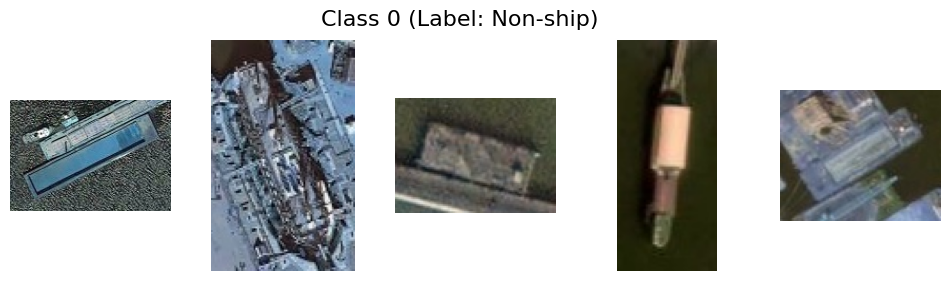

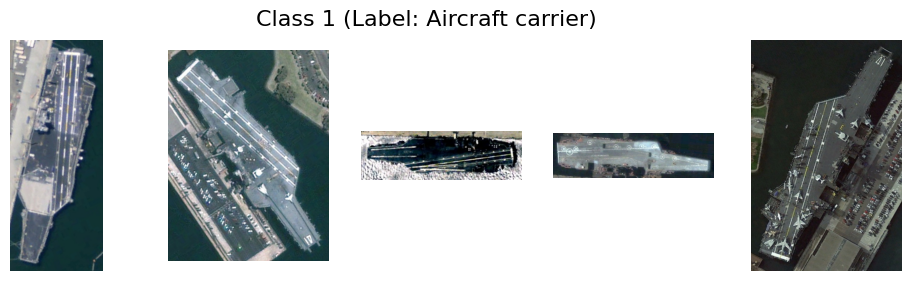

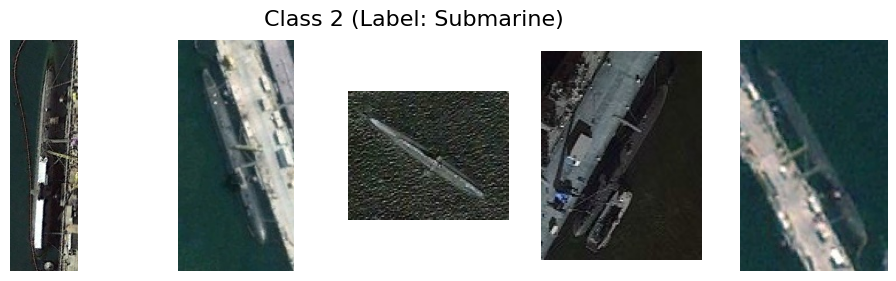

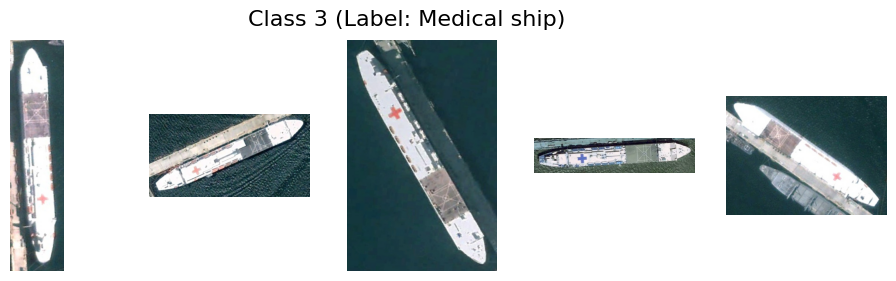

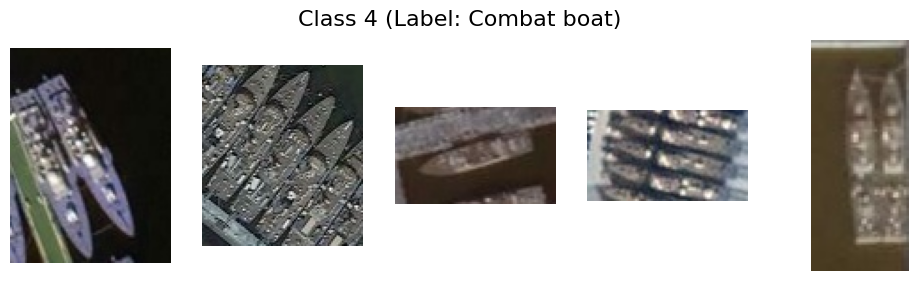

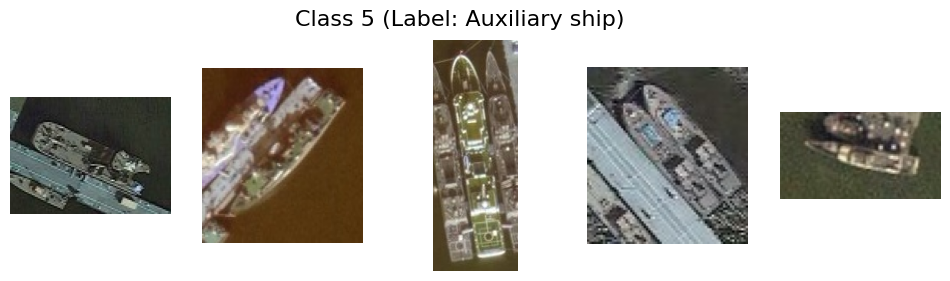

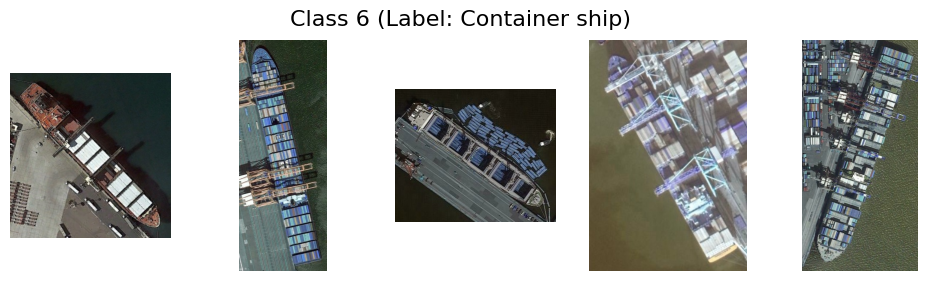

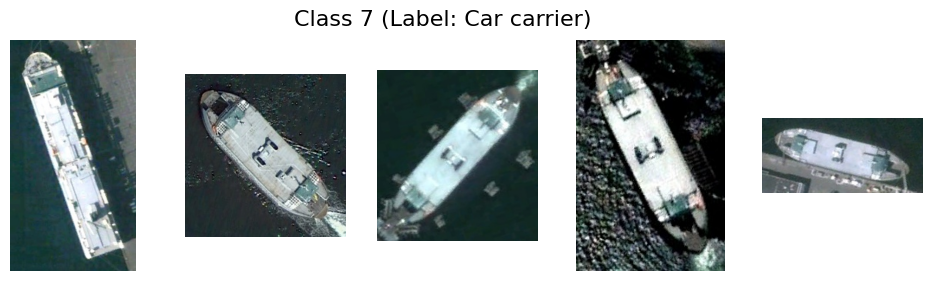

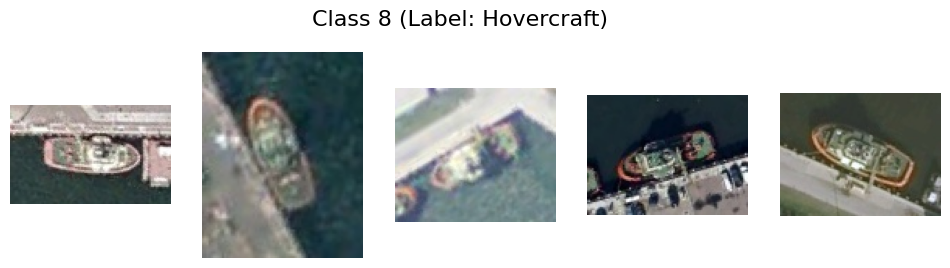

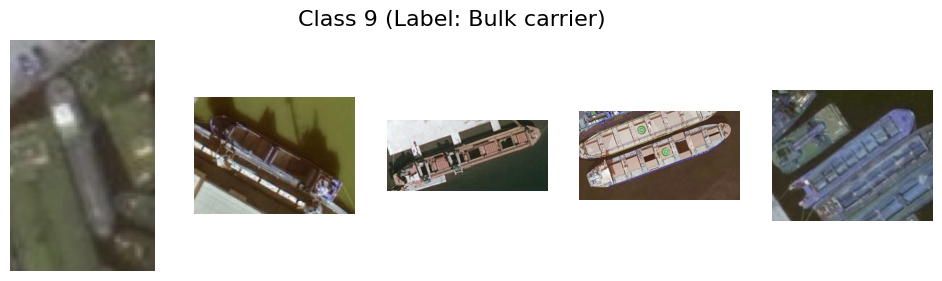

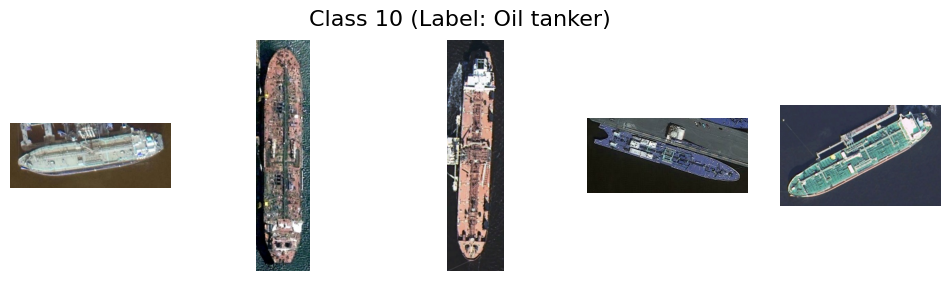

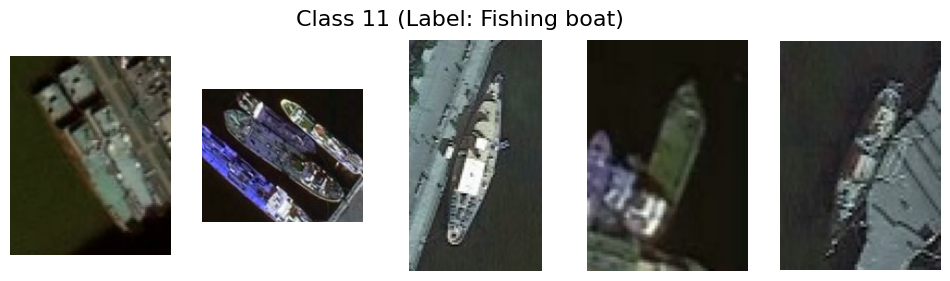

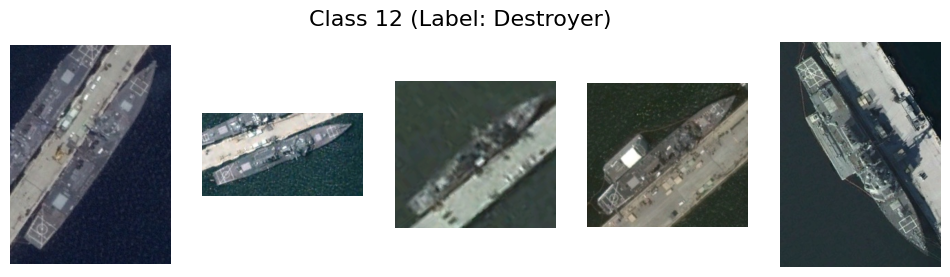

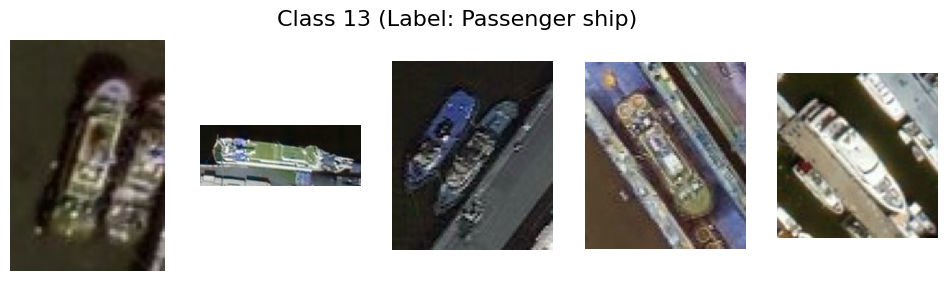

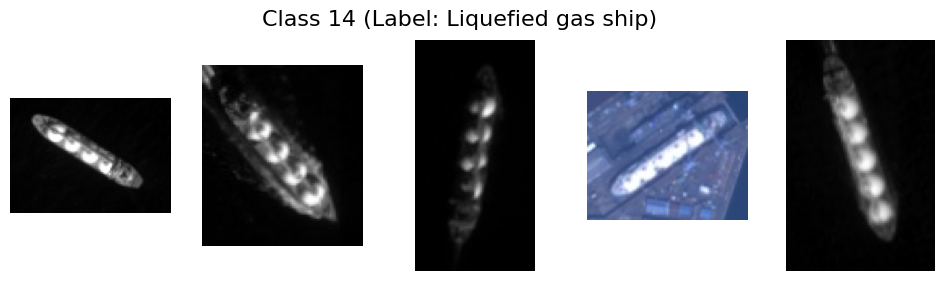

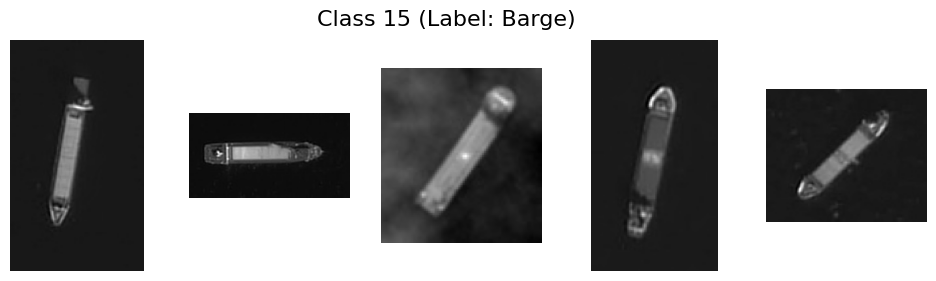

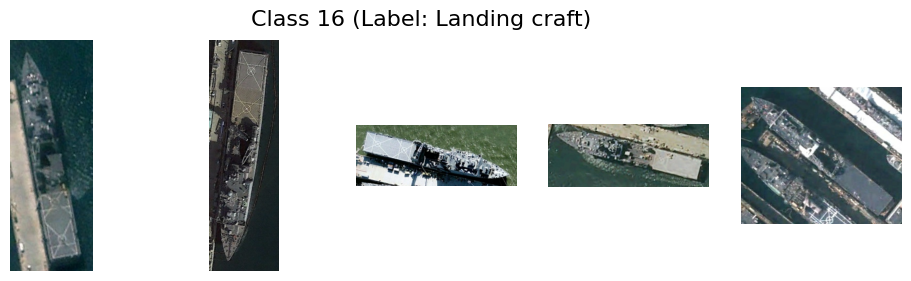

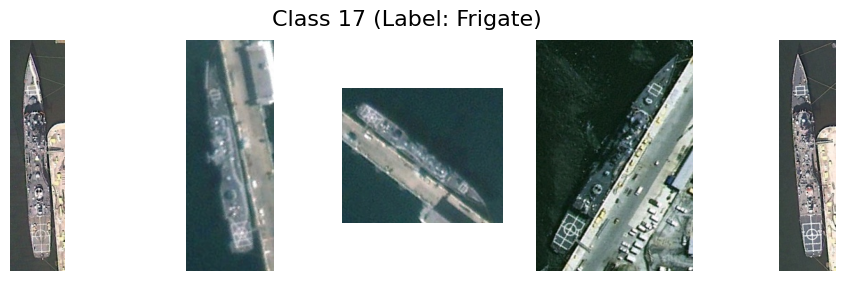

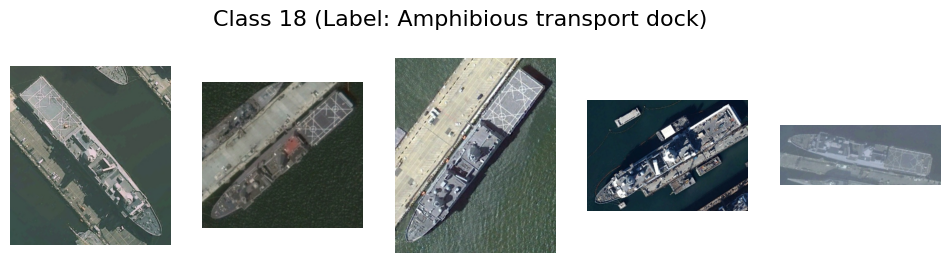

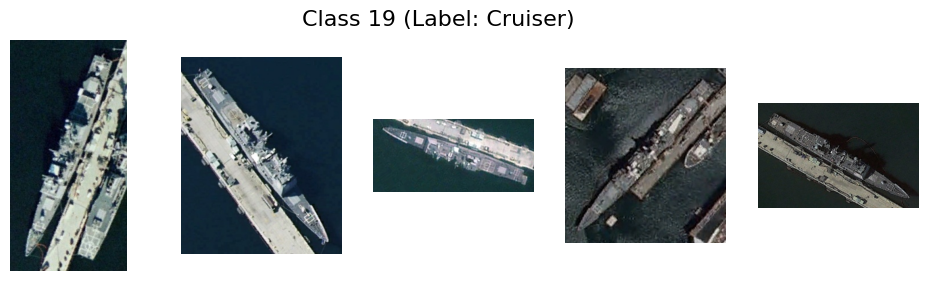

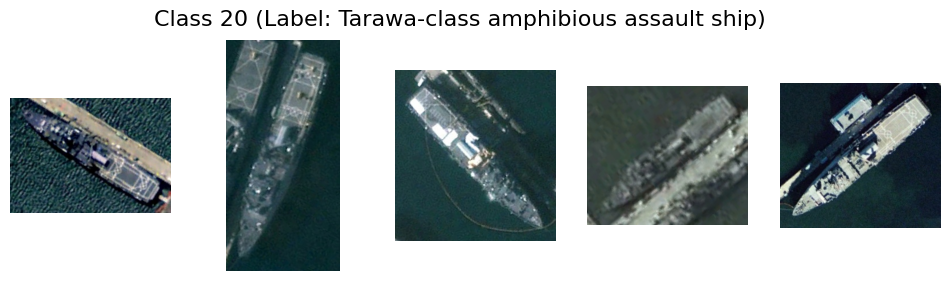

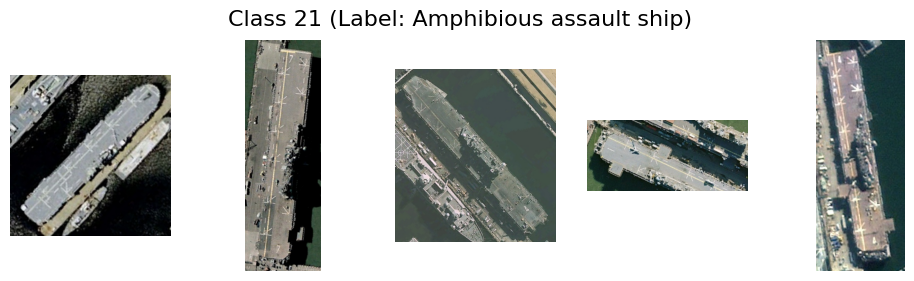

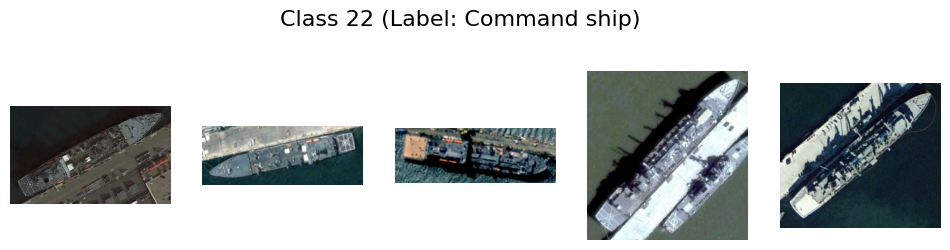

In [5]:
import numpy as np

import matplotlib.pyplot as plt

# Get unique class indices
unique_classes = np.sort(class_distribution['Class Index'].values)

for class_idx in unique_classes:
    # Get indices of images belonging to this class
    indices = [i for i, lbl in enumerate(labels) if lbl == class_idx]
    # Randomly select up to 5 indices
    selected = np.random.choice(indices, size=min(5, len(indices)), replace=False)
    # Load images
    images = [ds['train'][int(i)]['image'] for i in selected]
    
    # Plot images
    plt.figure(figsize=(12, 3))
    for j, img in enumerate(images):
        plt.subplot(1, 5, j+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Class {class_idx} (Label: {label_map[class_idx]})", fontsize=16)
    plt.show()

## 2.2. Deduplication of Near‑Identical Samples

To avoid over‑optimistic performance from duplicate or near‑duplicate images, we use a perceptual embedding and similarity-based deduplication pipeline:

1. **Feature extraction**  
   For each RGB image, we extract a deep embedding using a pretrained MobileNetV3 backbone.
2. **Similarity search within classes**  
   We compute cosine similarities between embeddings of images in the same class.
3. **Pruning near-duplicates**  
   Image pairs with similarity above a threshold (e.g., 0.95) are flagged as near-duplicates; we retain one representative and remove the rest.

The code below reports:
- The total number of near-duplicate images removed.
- The impact on each class.
- Examples of removed image pairs.

In [6]:
import torch
import numpy as np
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import os
import pandas as pd

# 1. Prepare transform and model
TARGET_SIZE = (448, 448)
transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225]),
])

mobilenet = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
backbone = torch.nn.Sequential(
    mobilenet.features,
    mobilenet.avgpool
).eval()

# 2. Extract embeddings for all RGB images in ds['train']
N = len(ds['train'])
with torch.no_grad():
    dummy = torch.zeros(1, 3, *TARGET_SIZE)
    emb_dim = backbone(dummy).view(1, -1).shape[1]

# Preallocate with max possible size, will trim later
embeddings = torch.zeros((N, emb_dim), dtype=torch.float32)
labels = np.zeros(N, dtype=int)
rgb_indices = []

row = 0
for idx in tqdm(range(N), desc="Embedding"):
    img = ds['train'][idx]['image']
    # Exclude grayscale images
    if img.mode != "RGB":
        continue
    label = ds['train'][idx]['label']
    img_t = transform(img).unsqueeze(0)
    with torch.no_grad():
        feat = backbone(img_t)
        feat = feat.view(1, -1)
        feat = torch.nn.functional.normalize(feat, dim=1)
    embeddings[row] = feat
    labels[row] = label
    rgb_indices.append(idx)
    row += 1

# Trim arrays to actual number of RGB images
embeddings = embeddings[:row]
labels = labels[:row]

# 3. Find near-duplicates within each class
threshold = 0.95
to_remove = set()
removed_pairs = []

for cls in np.unique(labels):
    cls_idx = np.where(labels == cls)[0]
    E = embeddings[cls_idx]
    sims = E @ E.T
    n = sims.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            sim = sims[i, j].item()
            if sim > threshold:
                keep_idx = int(rgb_indices[cls_idx[i]])
                drop_idx = int(rgb_indices[cls_idx[j]])
                to_remove.add(drop_idx)
                removed_pairs.append((keep_idx, drop_idx, sim))

print(f"Found {len(to_remove)} near-duplicate RGB images in ds['train']")

os.makedirs("results", exist_ok=True)
to_remove_list = sorted(list(to_remove))
pd.DataFrame({"index": to_remove_list}).to_csv("results/near_duplicate_indices.csv", index=False)

Embedding: 100%|██████████| 4080/4080 [05:44<00:00, 11.84it/s]


Found 256 near-duplicate RGB images in ds['train']


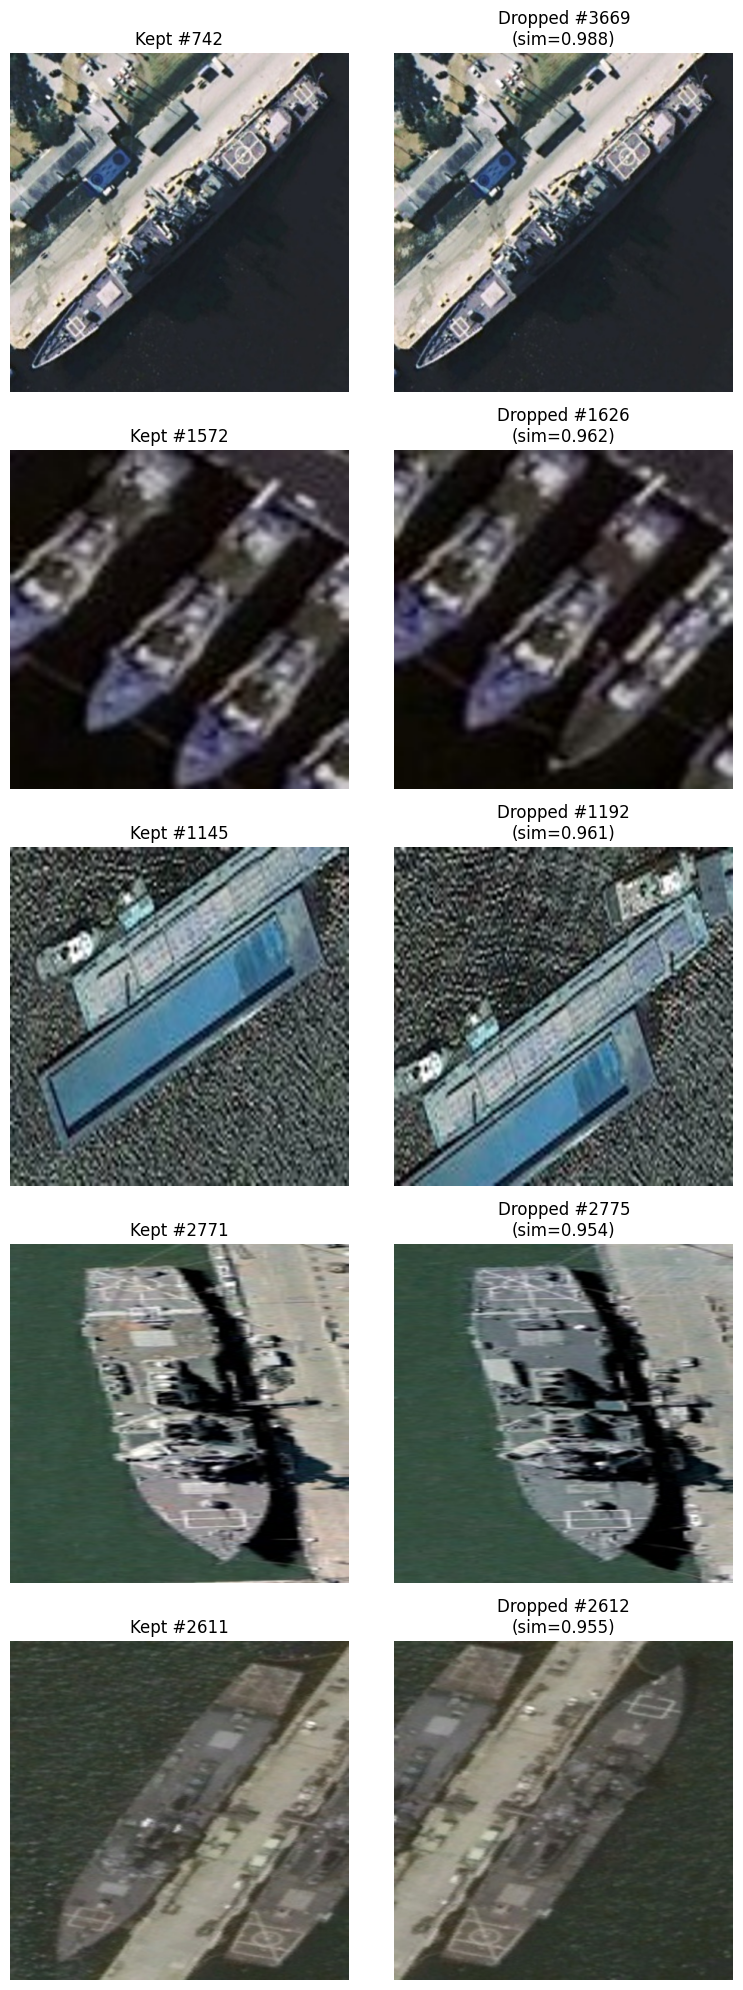

In [7]:
import random

# Sample 5 pairs to plot
sample = random.sample(removed_pairs, min(5, len(removed_pairs)))
fig, axes = plt.subplots(len(sample), 2, figsize=(8, 4 * len(sample)))
if len(sample) == 1:
    axes = [axes]

for ax_row, (keep_i, drop_i, sim) in zip(axes, sample):
    img_k = ds['train'][keep_i]['image'].resize(TARGET_SIZE)
    img_d = ds['train'][drop_i]['image'].resize(TARGET_SIZE)

    ax_row[0].imshow(img_k)
    ax_row[0].set_title(f"Kept #{keep_i}")
    ax_row[0].axis("off")

    ax_row[1].imshow(img_d)
    ax_row[1].set_title(f"Dropped #{drop_i}\n(sim={sim:.3f})")
    ax_row[1].axis("off")

plt.tight_layout()
plt.show()

In [8]:
# Remove selected images from ds['train']
if to_remove:
    keep_indices = [i for i in range(len(ds['train'])) if i not in to_remove]
    ds['train'] = ds['train'].select(keep_indices)

In [9]:
print(len(ds['train']))

3824


In [10]:
import pandas as pd

# Extract labels from the train split
labels = ds['train']['label']

# Map integer labels to string labels
string_labels = [label_map[lbl] for lbl in labels]

# Compute class counts
class_counts = pd.Series(string_labels).value_counts().sort_index()

# Display as a DataFrame, sorted by count descending
class_distribution = pd.DataFrame({
    'Class Index': [list(label_map.values()).index(name) for name in class_counts.index],
    'Class Name': class_counts.index,
    'Count': class_counts.values,
}).sort_values('Count', ascending=False).reset_index(drop=True)
print(class_distribution)

    Class Index                            Class Name  Count
0             2                             Destroyer    508
1             0                              Non-ship    470
2            17                          Bulk carrier    334
3             4                               Frigate    273
4             6                               Cruiser    270
5            10                             Submarine    220
6            13                        Auxiliary ship    207
7            18                            Oil tanker    164
8             1                      Aircraft carrier    156
9             8               Amphibious assault ship    137
10           12                           Combat boat    126
11           16                            Hovercraft    116
12            3                         Landing craft    107
13           19                          Fishing boat     99
14           14                        Container ship     96
15            5         

# 3. Geometric Preprocessing

In this section we preprocess the spatial dimensions and orientation of every image so that the classifier sees a consistent input format.

## 3.1. Resizing, Padding, and Aspect‑Ratio Preservation

All images are resized so that their longer side matches a target resolution (e.g. 448 px), then zero‑padded on the shorter side to produce square inputs.  This avoids both distortion and cropping of important ship features.

In [11]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageOps
import random

def resize_and_pad(img, target_size=TARGET_SIZE):
    if img.mode != "RGB":
        img = img.convert("RGB")
    iw, ih = img.size
    tw, th = target_size
    scale = min(tw/iw, th/ih)
    nw, nh = int(iw*scale), int(ih*scale)
    img = img.resize((nw, nh), Image.LANCZOS)
    dw, dh = tw-nw, th-nh
    pad = (dw//2, dh//2, dw-dw//2, dh-dh//2)
    return ImageOps.expand(img, pad, fill=(0,0,0))

# --- 1) Precompute resize+pad into a new DatasetDict ---
def preprocess_fn(example):
    # resize & pad the PIL image
    img = resize_and_pad(example["image"], target_size=TARGET_SIZE)
    # convert to HWC uint8 numpy array
    return {"pixels": np.asarray(img, dtype=np.uint8)}

ds = ds.map(
    preprocess_fn,
    remove_columns=["image"],   # drop the old PIL column
    num_proc=1                  # or >1 to parallelize
)

# now `ds[split]["pixels"]` is an ndarray H×W×C
# and `ds[split]["label"]` (or "labels") remains intact

Map: 100%|██████████| 3824/3824 [02:09<00:00, 29.47 examples/s]


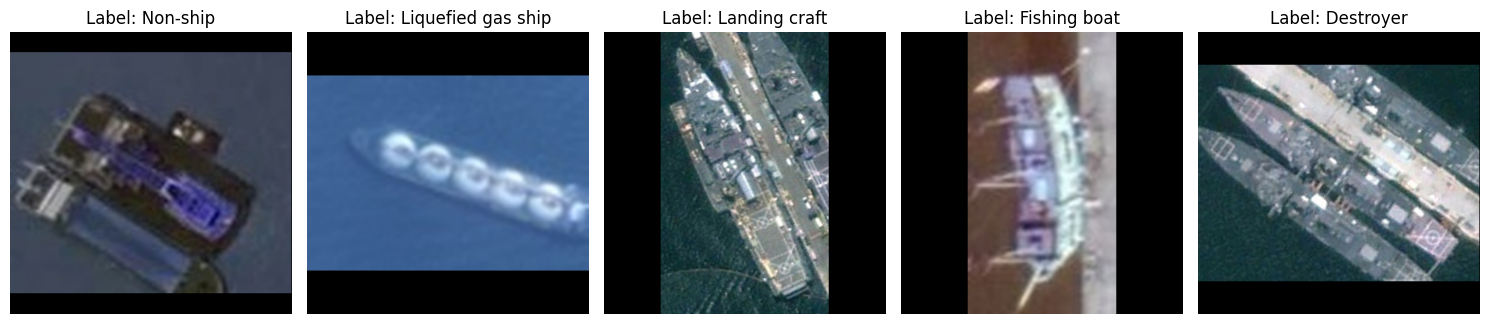

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt

# --- 2) Visualize 5 random samples from the 'train' split ---
split = "train"
n_samples = 5
indices = random.sample(range(len(ds[split])), n_samples)

fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
for ax, idx in zip(axes, indices):
    row = ds[split][idx]
    img   = row["pixels"]            # H×W×C numpy array
    label = row.get("label", row.get("labels"))
    ax.imshow(img)
    ax.set_title(f"Label: {label_map[label]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# 4. Image‑Quality Simulation & Measurement

In this section we simulate realistic degradations on our ship imagery and then compute no‑reference metrics to quantify each frame’s visibility.  These quality scores will drive both entropy‑regularized training and quality‑aware conformal calibration.

## 4.1. Synthetic Degradation Methods

To emulate the types of blur and low contrast seen in UAV or ship‑borne footage, we randomly apply two distortions:

- **Motion & Defocus Blur**  
  We convolve images with a Gaussian kernel of varying radius \(\sigma\) (e.g. 0–10 px) to mimic camera shake, focus drift, or platform vibration.

- **Haze Simulation**  
  We overlay a semi‑transparent veiling layer (or use a dark‑channel synthesis) to reproduce atmospheric scattering, sea spray, or low‑contrast fog.

Both degradations are applied at random per image according to user‑specified parameters (blur probability, haze intensity), yielding a mixed‐quality dataset for downstream processing.

- Motion & defocus blur
- Haze simulation
- Mask‑based occlusion

## 4.2. No‑Reference Quality Metrics

For every image—original and degraded—we compute a suite of no‑reference quality measures:

1. **Sharpness** (Variance of Laplacian)  
   \(\displaystyle \mathrm{Sharpness} = \operatorname{Var}\bigl(\nabla^2 I\bigr)\)  
   Lower values indicate heavier blur.

2. **Compression Artifacts** (BRISQUE Score)  
   A learned, data‑driven score in \([0,100]\); higher → more blocking and ringing.

3. **Haze Index** (Mean Dark‑Channel)  
   \(\displaystyle \mathrm{Haze} = \mathrm{mean}\bigl(\min_{c\in\{R,G,B\}} I_c\bigr)\) after local erosion; higher → more haze.

4. **Occlusion Ratio** (Cloud/Mask Fraction)  
   Fraction of pixels above a brightness threshold, used to estimate cloud cover or physical masking.

We will:

- **Plot histograms** of each metric **before vs. after** synthetic degradation.  
- **Display example pairs** of original and degraded images, annotated with their computed metrics.

These quality scores form the basis for our entropy‐regularization weights and for defining conformal calibration bins in Section 6.  

- Sharpness (variance of Laplacian)  
- Compression artefacts (PIQE/BRISQUE)  
- Haze index (dark‑channel prior)  
- Cloud/occlusion measure  

## 4.3. Composite Quality Score

While each no‑reference metric captures a distinct degradation mode, we need a single, unified proxy **Q** ∈ [0,1] for downstream calibration and training. We compute **Q** as follows:

1. **Min–Max Normalization**  
   - For each raw metric _m_, compute  
     `m_norm = (m – m_min) / (m_max – m_min)`  
   - If “higher is worse” (compression, haze, occlusion), invert:  
     `m_norm = 1 – m_norm`

2. **Gated Fusion**  
   - Define the three “clean” factors:  
     ```python
     sharp_n     = normalized sharpness
     brisque_inv = 1 - brisque_n       # compression inverted
     haze_inv    = 1 - haze_n          # haze inverted
     ```
   - Compute a weighted core score:  
     ```python
     core = w1*sharp_n + w2*brisque_inv + w3*haze_inv
     # with w1 + w2 + w3 = 1
     ```
   - Apply cloud gating so that full occlusion → zero quality:  
     ```python
     quality_score = (1 - cloud_n) * core
     # if cloud_n == 1.0, then quality_score == 0
     ```

3. **Geometric‑Mean Alternative**  
   As a smooth “AND” of all four factors, take their weighted geometric mean:  
   ```python
   # define cloud_free = 1 - cloud_n
   factors = [sharp_n, brisque_inv, haze_inv, cloud_free]
   weights = [w1, w2, w3, w4]  # sum to 1
   log_Q = sum(w * np.log(f + 1e-6) for w, f in zip(weights, factors))
   quality_score = np.exp(log_Q)

   This ensures any near‑zero factor drives quality_score toward zero.

4. **Illustrations**

   - Histogram of quality_score before vs. after synthetic degradation
   - Example images annotated with their composite score

This composite quality index Q will be used to:

   - Weight the entropy regularizer in Section 5.2
   - Define per‑bin conformal thresholds in Section 6.2

- Metric normalization  
- Fusion strategy (e.g. gated or geometric mean)  
- Score distributions and illustrative examples  

# 5. Classification Experiments

In this section we train and evaluate deep neural networks on our processed ship imagery, both with and without entropy regularization to enforce caution on low‑quality inputs. We compare multiple architectures and report accuracy, confusion matrices, and the relationship between image quality and model confidence.

## 5.1. Data Splitting

We partition the cleaned, preprocessed dataset into three disjoint subsets:

- **Training set (≈70 %)**  
  Used to fit the network parameters.  
- **Validation/Calibration set (≈15 %)**  
  Used both for early‑stopping and for computing conformal nonconformity thresholds per quality bin.  
- **Test set (≈15 %)**  
  Held out until the final evaluation to report unbiased accuracy and uncertainty metrics.

Splits are **stratified** by (super)class to preserve class balance. We will display:

- Number of images per class in each split  
- A table or bar chart summarizing sample counts 

- Stratified train/validation/calibration/test  
- Sample counts per class and split  

## 5.2. Model Architectures and Training

We implement and compare three convolutional backbones:

1. **ResNet‑18** (baseline)  
2. **EfficientNet‑B0** (lighter, better calibrated)  
3. **MobileNetV3‑Large** (mobile‑optimized)

For each model we train under two regimes:

- **Standard Cross‑Entropy**  
  `loss = CrossEntropy(logits, labels)`  

- **Entropy Regularization**  
  ```python
  # per‑sample entropy H = –∑ p·log p
  # weight w = (sigma / max_sigma)^k
  loss = CE_loss – λ * mean(w * H)
  where λ and k are hyperparameters to encourage higher entropy on heavily obscured images.

We will show:

Training & Validation Curves
Epoch‑wise accuracy and loss for each model+regime.

Hyperparameters
Learning rate, batch size, number of epochs, entropy weight λ.

- Baseline CNNs (e.g. ResNet‑18, EfficientNet‑B0, and MobileNet-V3)
- Entropy regularization for quality sensitivity (with and without)
- Training curves (train/val accuracy per epoch)  
- Comparison of 3× different models 

## 5.3. Evaluation on Held‑Out Data

On the test split, we report:

Overall Accuracy and Confusion Matrix for each model+regime.

Scatter Plot of quality_score vs. model confidence (true‑class probability), with points colored by correct/incorrect classification, for both validation and test sets.

Calibration Metrics (e.g. Expected Calibration Error) to quantify how well confidence aligns with accuracy.

These results will illustrate how entropy regularization and choice of backbone affect both raw performance and the model’s sensitivity to image quality.

- Overall accuracy and confusion matrices  
- Scatter: quality score vs. true‑class probability (val & test)  
- Correct vs. incorrect coloring

# 6. Conformal Prediction for Uncertainty

Once we have a trained, entropy‑regularized classifier, we wrap it in a conformal predictor to obtain **set‑valued** outputs with formal coverage guarantees.

## 6.1. Global Conformal Thresholds

1. **Nonconformity Score**  
   For each calibration sample \((x_i, y_i)\), compute  
   ```python
   p = softmax(model(x_i))
   score_i = 1 - p[y_i]    # lower = more confident in true label

2. **Quantile Calibration**
Choose a target miscoverage level 
𝛼
α (e.g. 0.1 for 90 % coverage).
Compute the 
(
1
−
𝛼
)
(1−α)-quantile of 
{
 
score
𝑖
}
{score 
i
​
 } over the entire calibration set:

q_global = np.quantile(scores, 1 - alpha)

3. **Prediction Sets**
At inference, for a new image 
𝑥
x, form the set

S(x) = { c : 1 - softmax(model(x))[c] <= q_global }
This set is guaranteed to contain the true label with probability ≥ 
1
−
𝛼
1−α across all quality levels combined.

- Nonconformity definition  
- Coverage and set‐size trade‑off  

6.1.1. Global Coverage and Set Size
Coverage Curve: fraction of test samples where 
𝑦
∈
𝑆
(
𝑥
)
y∈S(x).

Average Set Size: mean 
∣
𝑆
(
𝑥
)
∣
∣S(x)∣ over test images.

We will plot these as horizontal lines or single points to compare against quality‐aware methods.

## 6.2. Quality‑Dependent Buckets

A single global threshold may be too tight on low-quality images (under-coverage)
or too loose on high-quality ones (oversized sets). We address this by calibrating per-quality-bin.

Bin Definition
Divide the composite quality score Q ∈ [0,1] into B contiguous bins:
   bins  = np.linspace(0, 1, B+1)
   labels = [f"bin{i}" for i in range(B)]
   cal_df["q_bin"] = pd.cut(cal_df["quality_score"], bins=bins, labels=labels)

Per-Bin Calibration
For each bin b:
  scores_b = [score_i for i in cal_indices if q_bin_i == b]
  q_b      = np.quantile(scores_b, 1 - alpha)

Adaptive Prediction Sets
At inference, for a new image x:
   1. Compute Q(x) and assign it to bin b
   2. Use threshold q_b to form the set:
       S(x) = { c : 1 - p[c] <= q_b }
  This guarantees coverage ≥ (1 - alpha) within each quality bin.

### 6.2.1. Visualizing Thresholds and Performance

Threshold vs. Bin
Plot {q_b} as a function of the midpoint of each quality bin,
with a horizontal line for the global q_global.

Coverage by Bin
For each bin b:
  cov_b = mean( y_i in S(x_i) for test samples where q_bin_i == b )

Average Set Size by Bin
For each bin b:
  avg_size_b = mean( |S(x_i)| for test samples where q_bin_i == b )

Comparison
Show that quality-dependent calibration preserves the target coverage
across all bins, while a global threshold fails on extreme low-/high-quality images.

- Defining quality bins  
- Per‑bin thresholds vs. global  
- Coverage and average set size as a function of quality  

# 7. Discussion & Future Work

## 7.1. Insights and Limitations

## 7.2. Extensions (multi‑task blur estimation, ensembles, real UAV data)

# References